In [1]:
from IPython.display import display
from IPython.display import clear_output
import PIL
import numpy as np
import time
import os
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import gc
import sys
import seaborn as sns

import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

# from prednet import PredNet
# # from data_utils import SequenceGenerator
# from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import multiprocessing
import random
import sklearn
from sklearn import metrics
import seaborn as sns
import cv2
import skimage
from skimage import restoration
import copy

Using TensorFlow backend.


In [2]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

15000


In [3]:
RAD_id_submit_list = os.listdir("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_Test_2/")
print(len(RAD_id_submit_list))

8000


In [4]:
def check_RAD_id(RAD_id):
#     return RAD_id
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if mean_list.mean() < -0.5:
        return None
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return None
    return RAD_id

In [20]:
RAD_id_list = raw_RAD_id_list

In [5]:
pool = multiprocessing.Pool()
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# map(check_RAD_id, raw_RAD_id_list[:100])
# print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = list(pool.map(check_RAD_id, raw_RAD_id_list))
RAD_id_list = [x for x in RAD_id_list if x is not None]
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-10-04 11:24:06
end time: 2018-10-04 11:24:54
00:00:47
6562


In [6]:
step_size = 5

class trainGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X, y = data_generation(list_IDs_temp, batch_size=self.batch_size, image_size=self.image_size, nt=self.nt, step_size=step_size, image_scalar=self.image_scalar)
#         y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-10-04 11:24:54


In [25]:
n_channels = 1
def data_generation(list_IDs_temp, batch_size, image_size, nt, step_size, image_scalar, offset=None, path='/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train'):
    '''
    nt * step_size + offset = 60
    '''
    X = np.empty((batch_size, nt, image_size, image_size, n_channels))
    y = np.empty((batch_size, image_size, image_size, n_channels))
    for i, RAD_id in enumerate(list_IDs_temp):
        if offset == None:
            offset = random.randint(2, 59 - nt * step_size)
#             offset = random.randint(0, 61 - nt * step_size)
        for j in range(nt):
            temp_matrix = np.empty((n_channels, image_size, image_size))
#             temp_matrix[0] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * step_size + offset - 1)).resize((image_size, image_size))).astype(np.int8) / image_scalar + \
#                              np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * step_size + offset - 2)).resize((image_size, image_size))).astype(np.int8) / image_scalar
            temp_matrix[0] = np.array(PIL.Image.open("%s/%s/%s_%03d.png" % (path, RAD_id, RAD_id, j * step_size + offset)).resize((image_size, image_size))).astype(np.int8) / image_scalar
#             temp_matrix[2] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * step_size + offset + 1)).resize((image_size, image_size))).astype(np.int8) / image_scalar + \
#                              np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * step_size + offset + 2)).resize((image_size, image_size))).astype(np.int8) / image_scalar
#             temp_matrix[1] = cv2.GaussianBlur(temp_matrix[0], (5, 5), 0)
#             temp_matrix[2] = cv2.GaussianBlur(temp_matrix[0], (9, 9), 0)
#             temp_matrix[0] = cv2.GaussianBlur(temp_matrix[0], (13, 13), 0)
            temp_matrix = np.rollaxis(temp_matrix, 0, 3)
            X[i][j] = temp_matrix
        temp_matrix = np.empty((n_channels, image_size, image_size))
        temp_matrix[0] = np.array(PIL.Image.open("%s/%s/%s_%03d.png" % (path, RAD_id, RAD_id, nt * step_size + offset)).resize((image_size, image_size))).astype(np.int8) / image_scalar
#         temp_matrix[1] = cv2.GaussianBlur(temp_matrix[0], (5, 5), 0)
#         temp_matrix[2] = cv2.GaussianBlur(temp_matrix[0], (9, 9), 0)
        temp_matrix[0] = cv2.GaussianBlur(temp_matrix[0], (13, 13), 0)
        temp_matrix = np.rollaxis(temp_matrix, 0, 3)
        y[i] = temp_matrix
    return X, y

In [91]:
# Model parameters
image_size = 256
nt = 4 # number of timesteps used for sequences in training
image_scalar = 80
vmin = -1
vmax = 0.6 * image_scalar
n_channels, im_height, im_width = (n_channels, image_size, image_size)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)

# inputs = keras.layers.Input(shape=(nt,) + input_shape)
# network = inputs
# network = keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=network.shape, padding='same', return_sequences=False, dropout=0.8, recurrent_dropout=0.9, recurrent_activation='sigmoid')(network)
# network = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same')(network)
# outputs = network


sub_inputs = keras.layers.Input(shape=(nt,) + input_shape)
network = sub_inputs
network = keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=network.shape, padding='same', return_sequences=False, dropout=0.8, recurrent_dropout=0.9, recurrent_activation='sigmoid')(network)
network = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='tanh')(network)
# network.set_shape((nt, image_size, image_size, n_channels))
sub_outputs = network
sub_model = keras.models.Model(inputs=sub_inputs, outputs=sub_outputs)
inputs = sub_model.input
outputs = sub_model(inputs)
model = keras.models.Model(inputs=inputs, outputs=outputs)

def my_loss(y_true, y_pred):
#     w = tf.add(y_true, tf.constant(0.5))
#     w = tf.add(y_pred, w)
    y_true = tf.multiply(y_true, tf.constant(1.0*image_scalar))
    y_pred = tf.multiply(y_pred, tf.constant(1.0*image_scalar))
    loss = tf.losses.absolute_difference(y_true, y_pred)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred)
#     loss = tf.losses.log_loss(y_true, y_pred)
#     loss = tf.multiply(loss, tf.constant(1000000000.0))
    return loss


model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-10-04 14:15:25


In [89]:
for i in inputs.shape[0]:
    print(i)

TypeError: 'Dimension' object is not iterable

In [27]:
version = 'SRAD2018_Neutrino_ConvLSTM_v0.3.0.1_18.10.04.11.29'

In [28]:

# model.save('/home/hadoop/Documents/Neutrino/prednet/%s_initial.hdf5' % version)
model.save_weights('/home/hadoop/Documents/Neutrino/prednet/%s_initial_weights.hdf5' % version)
# model.save('/home/hadoop/Documents/Neutrino/prednet/%s.hdf5' % version)
# model.save_weights('/home/hadoop/Documents/Neutrino/prednet/%s_weights.hdf5' % version)

In [56]:
model.load_weights('/home/hadoop/Documents/Neutrino/prednet/%s_initial_weights.hdf5' % version)

In [ ]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [21]:
model.weights

[<tf.Variable 'conv_lst_m2d_1/kernel:0' shape=(3, 3, 1, 128) dtype=float32_ref>,
 <tf.Variable 'conv_lst_m2d_1/recurrent_kernel:0' shape=(3, 3, 32, 128) dtype=float32_ref>,
 <tf.Variable 'conv_lst_m2d_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(1, 1, 32, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(1,) dtype=float32_ref>]

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 4, 256, 256, 1)    0         
_________________________________________________________________
model_11 (Model)             (None, 256, 256, 1)       38177     
Total params: 38,177
Trainable params: 38,177
Non-trainable params: 0
_________________________________________________________________


In [84]:
lr_schedule = lambda epoch: 0.0003 if epoch < 10 else 0.00003    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0, write_graph=False)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [85]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = trainGenerator(list_IDs=RAD_id_list[-50:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = trainGenerator(list_IDs=RAD_id_list[:12], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=20, validation_data=valid_generator, validation_steps=12, use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))

start time: 2018-10-04 13:18:47
Epoch 1/20
30/30 [==============================] - 3s 86ms/step - loss: 2.0410 - val_loss: 0.9958
Epoch 2/20
30/30 [==============================] - 2s 67ms/step - loss: 1.8368 - val_loss: 0.9759
Epoch 3/20
30/30 [==============================] - 2s 67ms/step - loss: 1.4511 - val_loss: 1.2125
Epoch 4/20
30/30 [==============================] - 2s 67ms/step - loss: 1.3229 - val_loss: 1.2164
Epoch 5/20
30/30 [==============================] - 2s 68ms/step - loss: 1.6407 - val_loss: 1.2431
Epoch 6/20
30/30 [==============================] - 2s 66ms/step - loss: 1.4740 - val_loss: 1.2399
Epoch 7/20
30/30 [==============================] - 2s 71ms/step - loss: 1.3638 - val_loss: 1.1459
Epoch 8/20
30/30 [==============================] - 2s 67ms/step - loss: 1.6266 - val_loss: 1.3196
Epoch 9/20
30/30 [==============================] - 2s 70ms/step - loss: 1.4299 - val_loss: 1.0932
Epoch 10/20
30/30 [==============================] - 2s 68ms/step - loss: 1.3

# 测试

In [61]:
test_model = model

In [62]:
class testGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X, y = data_generation(list_IDs_temp, batch_size=self.batch_size, image_size=self.image_size, nt=self.nt, step_size=step_size, image_scalar=self.image_scalar)
#         y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-10-04 11:38:29


In [63]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = testGenerator(list_IDs=RAD_id_list[:1], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = testGenerator(list_IDs=RAD_id_list[-1:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)

start time: 2018-10-04 11:38:30


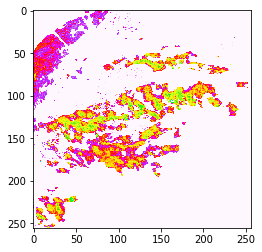

In [64]:
for data in [train_generator, valid_generator][0]:
    x, y_ = data
    break
c = 0
# for i in range(6):
#     plt.imshow(np.rollaxis(x[0][i], 2, 0)[c] * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
#     plt.show()
for c in range(n_channels):
    plt.imshow(np.rollaxis(x[0][-1], 2, 0)[c] * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
    plt.show()

In [65]:
x_.dtype

dtype('float64')

0 0


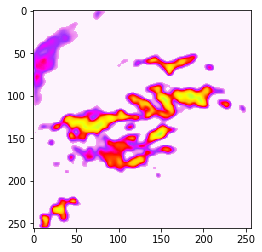

1 0


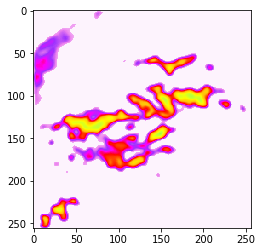

2 0


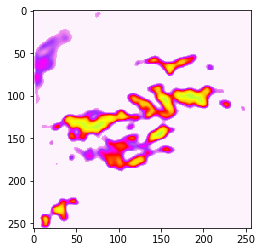

3 0


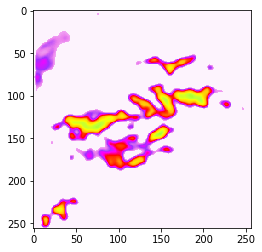

4 0


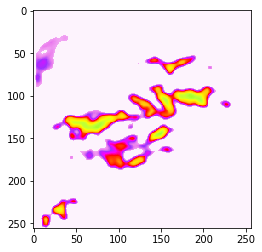

5 0


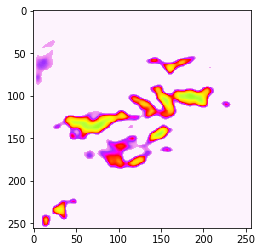

In [66]:
for RAD_id_counter, RAD_id in enumerate(RAD_id_list[:1]):
    x = np.empty((1, nt, image_size, image_size, n_channels), np.float64)
    for i in range(nt):
        x_, y_ = data_generation([RAD_id], batch_size=1, image_size=image_size, image_scalar=image_scalar, nt=nt, step_size=step_size, offset=30-nt+i, path='/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train')
        x[0][i] = test_model.predict(x_)
        x[0][i] = y_
    for i in range(30 // step_size):
        y = test_model.predict(x)
    #     temp_matrix = np.rollaxis(y[0], 2, 0)
    #     for k in range(3):
    #         psf_size = 15
    #         psf = np.ones((psf_size, psf_size)) / psf_size ** 2
    #         temp_matrix[k] = restoration.wiener(temp_matrix[k], psf, 5)
    #     y[0] = np.rollaxis(temp_matrix, 0, 3)
        y = np.where(y<0.03, -0.01, y)
    #     y = np.where(y>0.6, 0.6, y)
        for j in range(nt - 1):
            x[0][j] = x[0][j + 1]
        x[0][-1] = y[0]
        for k in range(n_channels):
            print(i, k)
            plt.imshow(np.rollaxis(y[0], 2, 0)[k] * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
            plt.show()

In [70]:
start_time = time.time()
print(time.strftime("start time: %Y-%m-%d %H:%M:%S", time.localtime()))
model_abs_loss = []
model_sqr_loss = []
last_frame_abs_loss = []
last_frame_sqr_loss = []
for RAD_id_counter, RAD_id in enumerate(RAD_id_list[-50:]):
    x, y = data_generation([RAD_id], batch_size=1, image_size=image_size, image_scalar=image_scalar, nt=nt, step_size=step_size, offset=30-nt*step_size)
    x_last = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30 - step_size)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size))
    y_true_last = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 60)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size))
#     for i in range(1):
    for i in range(30 // step_size + 1):
        y = test_model.predict(x)
        temp_matrix = np.rollaxis(y[0], 2, 0)
#         for k in range(n_channels):
#             temp_matrix[k] = rescale(x_last, temp_matrix[k], split=0.25)
        y[0] = np.rollaxis(temp_matrix, 0, 3)
        y = np.where(y<0.03, -0.01, y)
    #     y = np.where(y>0.6, 0.6, y)
        for j in range(nt - 1):
            x[0][j] = x[0][j + 1]
        x[0][-1] = y[0]
    x, y = x[0], y[0]
    y_pred_last = np.rollaxis(y, 2, 0)[0] * image_scalar 
#     y_pred_last = np.rollaxis(y, 2, 0)[0] * image_scalar + np.rollaxis(y, 2, 0)[1] * image_scalar + np.rollaxis(y, 2, 0)[2] * image_scalar# + np.rollaxis(y, 2, 0)[3] * image_scalar
#     y_pred_last = y_pred_last / 3
#     y_pred_last = rescale(x_last, y_pred_last, split=0.25)
    last_frame_abs_loss.append(sklearn.metrics.mean_absolute_error(y_true_last.astype(np.int), x_last.astype(np.int)))
    model_abs_loss.append(sklearn.metrics.mean_absolute_error(y_true_last.astype(np.int), y_pred_last.astype(np.int)))
    last_frame_sqr_loss.append(sklearn.metrics.mean_squared_error(y_true_last.astype(np.int), x_last.astype(np.int)))
    model_sqr_loss.append(sklearn.metrics.mean_squared_error(y_true_last.astype(np.int), y_pred_last.astype(np.int)))
    if RAD_id_counter % 10 == 0:
        print('RAD_id_counter=%5d\t\tIt takes %.2f' % (RAD_id_counter, time.time() - start_time))
model_abs_loss = np.array(model_abs_loss)
last_frame_abs_loss = np.array(last_frame_abs_loss)
model_sqr_loss = np.array(model_sqr_loss)
last_frame_sqr_loss = np.array(last_frame_sqr_loss)
print('     model_abs_loss=%.7f' % model_abs_loss.mean())
print('last_frame_abs_loss=%.7f' % last_frame_abs_loss.mean())
print('     model_sqr_loss=%.7f' % model_sqr_loss.mean())
print('last_frame_sqr_loss=%.7f' % last_frame_sqr_loss.mean())
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))
print(time.strftime("end time: %Y-%m-%d %H:%M:%S", time.localtime()))

start time: 2018-10-04 11:39:08
RAD_id_counter=    0		It takes 0.15
RAD_id_counter=   10		It takes 1.57
RAD_id_counter=   20		It takes 2.99
RAD_id_counter=   30		It takes 4.42
RAD_id_counter=   40		It takes 5.85
RAD_id_counter=   50		It takes 7.31
RAD_id_counter=   60		It takes 8.74
RAD_id_counter=   70		It takes 10.17
RAD_id_counter=   80		It takes 11.61
RAD_id_counter=   90		It takes 13.04
RAD_id_counter=  100		It takes 14.46
RAD_id_counter=  110		It takes 15.88
RAD_id_counter=  120		It takes 17.31
RAD_id_counter=  130		It takes 18.73
RAD_id_counter=  140		It takes 20.15
     model_abs_loss=2.4338664
last_frame_abs_loss=1.8920499
     model_sqr_loss=32.2183012
last_frame_sqr_loss=39.6207156
It took  00:00:21
end time: 2018-10-04 11:39:29


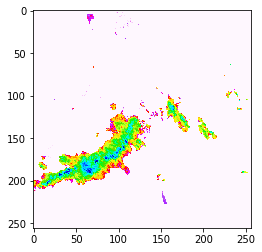

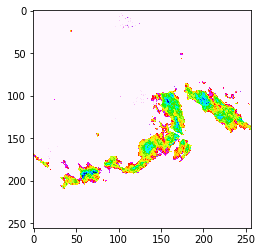

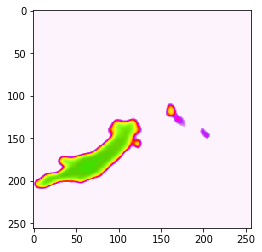

In [69]:
x_last = x_last.reshape(image_size, image_size)
plt.imshow(x_last, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
y_true_last = y_true_last.reshape(image_size, image_size)
plt.imshow(y_true_last, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
y_pred_last = y_pred_last.reshape(image_size, image_size)
plt.imshow(y_pred_last, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()

In [72]:
for RAD_id_counter, RAD_id in enumerate(RAD_id_list[-10:]):
    temp_RAD_id_list = [RAD_id]

    model.load_weights('/home/hadoop/Documents/Neutrino/prednet/%s_initial_weights.hdf5' % version)

    lr_schedule = lambda epoch: 0.0003 if epoch < 1 else 0.00003    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
    tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0, write_graph=False)
    callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

    start_time = time.time()
    print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
    train_generator = trainGenerator(list_IDs=temp_RAD_id_list, nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
    valid_generator = trainGenerator(list_IDs=RAD_id_list[:12], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
    history = model.fit_generator(train_generator, steps_per_epoch=300, epochs=2, validation_data=valid_generator, validation_steps=12, use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)
    print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
    print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))


    start_time = time.time()
    print(time.strftime("start time: %Y-%m-%d %H:%M:%S", time.localtime()))
    model_abs_loss = []
    model_sqr_loss = []
    last_frame_abs_loss = []
    last_frame_sqr_loss = []
    for RAD_id_counter, RAD_id in enumerate(temp_RAD_id_list):
        x, y = data_generation([RAD_id], batch_size=1, image_size=image_size, image_scalar=image_scalar, nt=nt, step_size=step_size, offset=30-nt*step_size)
        x_last = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30 - step_size)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size))
        y_true_last = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 60)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size))
        for i in range(1):
#         for i in range(30 // step_size + 1):
            y = test_model.predict(x)
            temp_matrix = np.rollaxis(y[0], 2, 0)
    #         for k in range(n_channels):
    #             temp_matrix[k] = rescale(x_last, temp_matrix[k], split=0.25)
            y[0] = np.rollaxis(temp_matrix, 0, 3)
            y = np.where(y<0.03, -0.01, y)
        #     y = np.where(y>0.6, 0.6, y)
            for j in range(nt - 1):
                x[0][j] = x[0][j + 1]
            x[0][-1] = y[0]
        x, y = x[0], y[0]
        y_pred_last = np.rollaxis(y, 2, 0)[0] * image_scalar 
    #     y_pred_last = np.rollaxis(y, 2, 0)[0] * image_scalar + np.rollaxis(y, 2, 0)[1] * image_scalar + np.rollaxis(y, 2, 0)[2] * image_scalar# + np.rollaxis(y, 2, 0)[3] * image_scalar
    #     y_pred_last = y_pred_last / 3
    #     y_pred_last = rescale(x_last, y_pred_last, split=0.25)
        last_frame_abs_loss.append(sklearn.metrics.mean_absolute_error(y_true_last.astype(np.int), x_last.astype(np.int)))
        model_abs_loss.append(sklearn.metrics.mean_absolute_error(y_true_last.astype(np.int), y_pred_last.astype(np.int)))
        last_frame_sqr_loss.append(sklearn.metrics.mean_squared_error(y_true_last.astype(np.int), x_last.astype(np.int)))
        model_sqr_loss.append(sklearn.metrics.mean_squared_error(y_true_last.astype(np.int), y_pred_last.astype(np.int)))
        if RAD_id_counter % 10 == 0:
            print('RAD_id_counter=%5d\t\tIt takes %.2f' % (RAD_id_counter, time.time() - start_time))
    model_abs_loss = np.array(model_abs_loss)
    last_frame_abs_loss = np.array(last_frame_abs_loss)
    model_sqr_loss = np.array(model_sqr_loss)
    last_frame_sqr_loss = np.array(last_frame_sqr_loss)
    print('     model_abs_loss=%.7f' % model_abs_loss.mean())
    print('last_frame_abs_loss=%.7f' % last_frame_abs_loss.mean())
    print('     model_sqr_loss=%.7f' % model_sqr_loss.mean())
    print('last_frame_sqr_loss=%.7f' % last_frame_sqr_loss.mean())
    print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))
    print(time.strftime("end time: %Y-%m-%d %H:%M:%S", time.localtime()))

start time: 2018-10-04 12:20:52
Epoch 1/2
300/300 [==============================] - 37s 124ms/step - loss: 3.8643 - val_loss: 1.1551
Epoch 2/2
300/300 [==============================] - 37s 125ms/step - loss: 3.7257 - val_loss: 1.0849
end time: 2018-10-04 12:22:07
It took  00:01:14
start time: 2018-10-04 12:22:07
RAD_id_counter=    0		It takes 0.04
     model_abs_loss=3.5495453
last_frame_abs_loss=5.1822357
     model_sqr_loss=58.0821075
last_frame_sqr_loss=156.3249664
It took  00:00:00
end time: 2018-10-04 12:22:07
start time: 2018-10-04 12:22:07
Epoch 1/2
300/300 [==============================] - 37s 124ms/step - loss: 3.1990 - val_loss: 1.0818
Epoch 2/2
300/300 [==============================] - 37s 124ms/step - loss: 2.8337 - val_loss: 0.9516
end time: 2018-10-04 12:23:22
It took  00:01:14
start time: 2018-10-04 12:23:22
RAD_id_counter=    0		It takes 0.04
     model_abs_loss=5.2656555
last_frame_abs_loss=5.0580902
     model_sqr_loss=97.4377441
last_frame_sqr_loss=109.8455963
It

In [ ]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))

In [ ]:
def check_RAD_id(RAD_id):
    sum_list = []
    for k in range(61):
        sum_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().sum())
    sum_list = np.array(sum_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, sum_list[:7])
    if sum_list.mean() < 251001 * 0:
        return False
    for k in range(59):
        if abs(sum_list[k] + sum_list[k + 2] - 2 * sum_list[k + 1]) > 251001 * 2:
            return False
    return True

In [ ]:
RAD_id_list = raw_RAD_id_list

In [ ]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list[:100]):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

In [ ]:
def read_by_RAD_id(RAD_id, offset):
    x_matrix = np.empty((31, 501, 501, 1))
    for i in range(31):
        x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    y_matrix = np.empty((501, 501, 1))
    y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    return ([x_matrix], [y_matrix])

In [ ]:
all_start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# sess.close()
# with tf.device("/gpu:0"):
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholder
x = tf.placeholder(tf.float32, shape=[None, 31, 501, 501, 1], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 501, 501, 1], name='y_')

# define the network
# network = tl.layers.InputLayer(x, name='input')
network = x
network = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=x.shape, padding='same', return_sequences=False, dropout=0.8, recurrent_dropout=0.9)(network)
network = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same')(network)

y = network
# cost = tf.losses.mean_squared_error(y, y_, weights=y_)
cost = tf.losses.mean_squared_error(y, y_)

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

sess.run(tf.global_variables_initializer())

n_epoch = 20
print_freq = 5

sum_cost = 0
for epoch in range(n_epoch):
    for i in range(1):
        for j in range(0, 10, 3):
            X_train, Y_train = read_by_RAD_id(RAD_id_list[i], j)
            feed_dict = {x: X_train, y_: Y_train}
        #     feed_dict.update(network.all_drop)  # enable noise layers
            train_cost, _ = sess.run([cost, train_op], feed_dict=feed_dict)
            sum_cost += train_cost / (Y_train[0].sum() + 251001)
        if i % print_freq == 0:
            print('%3d'%epoch, '%3d'%i, RAD_id_list[i], '%3d'%j, time.strftime('%H:%M:%S', time.localtime()), time.strftime('%H:%M:%S', time.gmtime(time.time() - all_start_time)), '%5.5f'%(sum_cost * 10 ** 10))
        sum_cost = 0

In [ ]:
feed_dict = {x: X_train}
prediction = sess.run(y, feed_dict=feed_dict)
prediction = prediction[0] * SCALAR
Y_validation = Y_train[0] * SCALAR
plt.imshow(Y_validation.reshape((501,501)), cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
prediction = np.where(prediction<3, -1, prediction)
plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
plt.show()
print('\n------------------------------------\n')

In [ ]:
for i in range(1):
    for j in range(0, 20, 7):
        X_train, Y_train = read_by_RAD_id(RAD_id_list[i], j)
        feed_dict = {x: X_train}
        prediction = sess.run(y, feed_dict=feed_dict)
        prediction = prediction[0] * SCALAR
        Y_validation = Y_train[0] * SCALAR
        plt.imshow(Y_validation.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction = np.where(prediction<3, -1, prediction)
        plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')

In [ ]:
def read_by_RAD_id(RAD_id, offset):
    x_matrix = np.empty((31, 501, 501, 1))
    for i in range(31):
        x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    y_matrix = np.empty((501, 501, 1))
    y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + offset))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    return ([x_matrix], [y_matrix])

In [ ]:
for i in range(1):
    RAD_id = RAD_id_list[i]
    
    for j in range(30):
        x_matrix = np.empty((31, 501, 501, 1))
        for k in range(31):
            x_matrix[k] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, k + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        feed_dict = {x: [x_matrix]}
        prediction = sess.run(y, feed_dict=feed_dict)
        prediction = prediction[0] * SCALAR
        y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        plt.imshow(y_matrix.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction = np.where(prediction<3, -1, prediction)
        plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')

In [ ]:
prediction.ravel()

In [ ]:
all_start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# sess.close()
# with tf.device("/gpu:0"):
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholder
x = tf.placeholder(tf.float32, shape=[None, 31, 501, 501, 1], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 501, 501, 1], name='y_')

# define the network
# network = tl.layers.InputLayer(x, name='input')
network = x
network = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), input_shape=x.shape, padding='same', return_sequences=False, dropout=0.8, recurrent_dropout=0.9)(network)
network = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same')(network)

y = network
# cost = tf.losses.mean_squared_error(y, y_, weights=y_)
w = tf.add(tf.constant(0.2), y_)
w = tf.add(w, y)
cost = tf.losses.mean_squared_error(y, y_, weights=w)
# cost = tf.losses.mean_squared_error(y, y_)

train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
# train_op = tf.train.GradientDescentOptimizer(learning_rate=0.003).minimize(cost)

sess.run(tf.global_variables_initializer())

n_epoch = 20
print_freq = 5

sum_cost = 0
for epoch in range(n_epoch):
    for i in range(1):
        RAD_id = RAD_id_list[i]
        x_matrix = np.empty((31, 501, 501, 1))
        for k in range(30):
            x_matrix[k + 1] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, k))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        prediction = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        for j in range(1):
            for k in range(30):
                x_matrix[k] = x_matrix[k + 1]
            x_matrix[30] = prediction
            
            feed_dict = {x: [x_matrix], y_: [y_matrix]}
            train_cost, _ = sess.run([cost, train_op], feed_dict=feed_dict)
            sum_cost += train_cost / (y_matrix.sum() + 251001)
            if i % print_freq == 0:
                print('%3d'%epoch, '%3d'%i, RAD_id_list[i], '%3d'%j, time.strftime('%H:%M:%S', time.localtime()), time.strftime('%H:%M:%S', time.gmtime(time.time() - all_start_time)), '%5.5f'%(sum_cost * 10 ** 10))
                sum_cost = 0
                
            feed_dict = {x: [x_matrix]}
            prediction = sess.run(y, feed_dict=feed_dict)
            prediction = prediction[0] * SCALAR
            y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
#             plt.imshow(y_matrix.reshape((501,501)), cmap=cm.gist_ncar_r)
#             plt.show()
#             print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
            prediction = np.where(prediction<3, -1, prediction)
#             plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
#             plt.show()
#             print('\n------------------------------------\n')
            prediction = prediction / SCALAR


In [ ]:
for i in range(1):
    RAD_id = RAD_id_list[i]
    x_matrix = np.empty((31, 501, 501, 1))
    for k in range(30):
        x_matrix[k + 1] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, k))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    prediction = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    for j in range(30):
        for k in range(30):
            x_matrix[k] = x_matrix[k + 1]
        x_matrix[30] = prediction
        feed_dict = {x: [x_matrix]}
        prediction = sess.run(y, feed_dict=feed_dict)
        prediction = prediction[0] * SCALAR
        y_matrix = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 31 + j))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
        plt.imshow(y_matrix.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction = np.where(prediction<3, -1, prediction)
        plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')
        prediction = prediction / SCALAR